(sec:dynamic_programming_2)=
# 플로이드-워셜 알고리즘

**소스코드**

아래 내용을 
[(구글 코랩) 플로이드-워셜 알고리즘](https://colab.research.google.com/github/codingalzi/algopy/blob/master/jupyter-book/dynamic_programming_2.ipynb)에서 
직접 실행할 수 있다.

**주요 내용**

- 방향 그래프
- 최단 경로 문제
- 플로이드-워셜 알고리즘
- 최적의 원칙

## 그래프 용어

그래프 관련 용어를 익혀두어야 한다.

| 용어 | 개념 |
| :--- | :--- |
| 노드<font size='2'>node</font> | 그래프의 구성 요소. 꼭짓점<font size='2'>vertex</font> 또는 정점으로도 불림. |
| 간선<font size='2'>edge</font> | 두 개의 노드를 연결하는 선. 이음선 또는 변으로도 불림. |
| 방향 그래프<font size='2'>directed graph</font> | 간선의 방향이 정해진 그래프 |
| 무방향 그래프<font size='2'>undirected graph</font> | 간선의 방향이 없는 그래프 |
| 가중치<font size='2'>weight</font> | 간선에 추가된 숫자 |
| 가중 그래프<font size='2'>weighted graph</font> | 가중치가 있는 간선을 사용하는 그래프 |
| 경로<font size='2'>path</font> | 간선으로 연결된 노드들의 나열. 즉, 하나의 노드에서 다른 노드로 가는 간선들의 연결. |
| 단순 경로<font size='2'>simple path</font> | 같은 노드를 두 번 지나지 않는 경로 |
| 순환<font size='2'>cycle</font> | 하나의 노드에서 출발하여 다시 그 노드로 돌아오는 경로 |
| 순환 그래프<font size='2'>cyclic graph</font> | 순환이 포함된 그래프 |
| 비순환 그래프 <font size='2'>acyclic graph</font> | 순환이 포함되지 않은 그래프 |
| 경로의 길이 | 가중 그래프의 경우엔 경로 상에 있는 가중치의 합, 비가중 그래프의 경우엔 경로 상에 있는 이음선의 수 |

예를 들어 가중 방향 그래프는 다음과 같이 생겼다.

참고: 아래 코드는 `graphviz` 라이브러리를 이용하여 그래프를 그려준다.
알고리즘 이해와는 상관없기에 코드가 아닌 그래프 결과물에만 집중하면 된다.

In [1]:
import graphviz 

def save_graph_as_svg(dot_string, output_file_name):
    if type(dot_string) is str:
        g = graphviz.Source(dot_string)
    elif isinstance(dot_string, (graphviz.dot.Digraph, graphviz.dot.Graph)):
        g = dot_string
    g.format='svg'
    # 이미지 저장 경로 지정
    g.filename = output_file_name
    g.directory = './imgs'
    g.render(view=False)
    return g

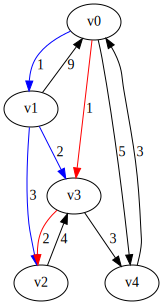

In [2]:
digraph1 = graphviz.Digraph()
digraph1.node("v0")
digraph1.node("v1")
digraph1.node("v2")
digraph1.node("v3")
digraph1.node("v4")
digraph1.edge("v0", "v1", label='1', color='blue')
digraph1.edge("v0", "v3", label='1', color='red')
digraph1.edge("v0", "v4", label='5')
digraph1.edge("v1", "v0", label='9')
digraph1.edge("v1", "v2", label='3', color='blue')
digraph1.edge("v1", "v3", label='2', color='blue')
digraph1.edge("v2", "v3", label='4')
digraph1.edge("v3", "v2", label='2', color='red')
digraph1.edge("v3", "v4", label='3')
digraph1.edge("v4", "v0", label='3')

save_graph_as_svg(digraph1.source, 'weighted_directed_graph_01')

## 최단 경로 문제

방향 그래프가 주어졌을 때
임의의 노드에서 다른 임의의 노드로 가는 최단 경로를 구하는 문제이다. 
이때 간선의 가중치와 방향을 함께 고려한다. 
비가중 방향 그래프의 경우 모든 간선의 가중치가 1이라고 간주한다.
최단 경로는 순환을 포함하지 않는 단순 경로만 대상으로 최단 경로를 찾는다.
최단 경로 계산 알고리즘은 예를 들어 두 도시 간의 최단 경로를 찾아야 할 때 활용될 수 있다.

위 가중 방향 그래프에서 $v_0$에서 $v_2$로 가는 단순 경로는 다음 세 종류이다.

* $v_0 \to v_1 \to v_2$: 경로 길이는 1 + 3 = 4.
* $v_0 \to v_3 \to v_2$: 경로 길이는 1 + 2 = 3.
* $v_0 \to v_1 \to v_3 \to v_2$: 경로 길이는 1 + 2 + 2 = 5.

이중에서 $v_0 \to v_3 \to v_2$가 $v_0$에서 $v_2$로 가는 최단 경로이다.

**완전 탐색**

완전 탐색<font size='2'>brute force</font> 알고리즘은
두 노드 사이의 가능한 모든 경로의 길이를 계산한 후 그 중에 최단 경로를 선택한다.
하지만 이 알고리즘은 지수 함수보다 나쁜 시간복잡도를 가진다.

예를 들어 $v_0, v_1, ..., v_{n-1}$을 노드로 사용하고 모든 노드들 사이에 간선이 존재하는 그래프를 고려하자.
이때 $v_0$에서 $v_{n-1}$으로 가는 경로 중에서 나머지 모든 노드를 한 번씩 꼭 거쳐서 가는 경로들의 수는
다음과 같이 계산된다.

* $v_0$ 에서 출발하여 첫 경유지로 사용될 수 있는 노드의 수는 $(n-2)$ 개
* 그 중에 하나를 선택하면, 그 다음 경유지로 사용될 수 있는 노드의 가지 수는 $(n-3)$개
* ...

따라서 총 경로의 개수는 다음과 같다.

$$(n-2)\cdot(n-3)\cdots 2\cdot 1= (n-2)!$$

두 노드 사이의 최단 경로를 동적계획법으로 계산하기 위해
주어진 방향 그래프의 **인접 행렬**<font size='2'>adjacent matrix</font>을
동적계획법 기법으로 업데이트하여 두 노드 사이의 최단 경로를 계산한다. 

**인접 행렬**

가중 그래프의 인접 행렬은 노드와 노드를 잇는 간선과 가중치의 정보를 표현하는 $n\times n$ 행렬이다.
여기서 $n$은 노드의 개수를 가리킨다.
인접 행렬은 다음과 같이 정의되는 $n\times n$ 행렬 $W$로 표현된다.

$$
W[i][j] = 
\begin{cases}
\text{간선 가중치} & \quad\text{$v_i$ 에서 $v_j$ 로의 간선이 존재하는 경우} \\
\infty & \quad\text{$v_i$ 에서 $v_j$ 로의 간선이 존재하지 않는 경우} \\
0 & \quad \text{$i = j$ 인 경우}
\end{cases}
$$

앞서 예제로 언급된 가중 방향 그래프의 인접 행렬은 다음과 같다.
단, `inf`는 두 노드 사이에 간선이 없는 경우를 가리키며 
무한<font size='2'>infinity</font>을 의미한다.

In [3]:
# 무한에 해당하는 기호 사용
from math import inf

# inf 는 두 노드 사이에 간선이 없음을 의미함.
W = [[0, 1, inf, 1, 5],
     [9, 0, 3, 2, inf],
     [inf, inf, 0, 4, inf],
     [inf, inf, 2, 0, 3],
     [3, inf, inf, inf, 0]]

**동적계획법 전략**

$v_i$에서 $v_j$로 가는 최단 경로를 계산하기 위해
경유 노드를 확대해 나가면서 최단 경로를 업데이트하는 전략을 사용한다. 
이를 위해 $k$를 $0$부터 $n$까지 변하게 하면서 아래 조건에 맞는 행렬 $D^{(k)}$를
순차적으로 생성한다. 

$$
\begin{align*}
D^{(k)}[i][j] &= \text{집합 $\{v_0, v_1, \dots, v_{k-1}\}$ 에 속하는 노드만을 경유해서} \\
& \,\,\quad\,\text{$v_i$ 에서 $v_j$ 로 가는 최단 경로의 길이}
\end{align*}
$$

먼저, $D^{(0)}= W$이 성립한다.
이유는 $k=0$ 이면 $k-1=-1$ 이고, 따라서 $\{v_0, v_1, \dots, v_{k-1}\}$ 는 공집합으로 간주되기에 
두 노드를 연결하는 경로를 찾을 때 어떤 다른 노드를 경유하지 않아야 하기 때문이다.
즉, 두 노드를 직접 연결하는 간선만 사용할 수 있다.

반면에 $D^{(n)}$은 두 노드 사이의 최단 경로의 길이로 구성된다.
이유는 최단 경로를 결정할 때 어떤 노드를 거쳐야 하는제 제한이 없기 때문이다.
이제 남은 과제는 "어떻게 $D^{(0)}$에서 출발하여 $D^{(n)}$을 계산할 것인가?" 이다. 

먼저, 0보다 큰 $k$에 대해 $D^{(k)}[i][j]$ 를 재귀적으로 정의할 수 있음에 주목한다.

$$D^{(k)}[i][j] = \min \big( D^{(k-1)}[i][j],\,D^{(k-1)}[i][k] + D^{(k-1)}[k][j] \big)$$

이유는 다음과 같이 두 경우를 고려하면 되기 때문이다.

* 경우 1
    - $\{v_0, v_1,\dots, v_{k-1}\}$ 에 속한 노드들만을 통해서 $v_i$에서 $v_j$로 가는 최단 경로가 $v_{k-1}$를 경유하는 경우.
    - $v_{k-1}$가 무시되기에 결국 $\{v_0, v_1,\dots, v_{k-2}\}$ 만 경유하는 최단 거리와 동일함.
    
    $$D^{(k)}[i][j] = D^{(k-1)}[i][j]$$
    <br>

* 경우 2
    - $\{v_0, v_1,\dots, v_{k-1}\}$ 에 속한 노드들만을 통해서 $v_i$에서 $v_j$로 가는 최단 경로가 $v_{k-1}$를 경유하지 않는 경우.
    - 단순 경로만 고려해야 하기에 다음 $v_{k-1}$을 한 번만 경유하며 따라서 다음 식이 성립함.
    
    $$D^{(k)}[i][j] = D^{(k-1)}[i][k] + D^{(k-1)}[k][j]$$

위 재귀적 성질을 동적계획법으로 구현하고자 한다.
먼저, 동적계획법의 적용과정을 예제를 이용하여 설명한다.
다음은 앞서 언급된 재귀적 성질을 이용하여 $D^{(k)}[1][4]$를 동적계획법으로 계산하는 과정을 보여준다.

* $D^{(0)}[1][4] = W[1][4] = \infty$ 

* $D^{(1)}[1][4] = \min (D^{(0)}[1][4], d^{(1)}) = \min(\infty, 14) = 14$
    - $d^{(1)}$은 $v_0$를 경유하는 최단 경로 길이: 
    
    $$d^{(1)} = \text{len}([v_1, v_0, v_4]) = 9+5 = 14$$

* $D^{(2)}[1][4] = D^{(1)}[1][4] = 14$
    - $v_0$와 $v_1$을 경유할 수 있는 최단 경로 길이는 $v_0$를 경유할 수 있는 최단 경로 길이와 동일

* $D^{(3)}[1][4] = D^{(2)}[1][4] = 14$
    - $v_2$를 경유할 수 없음. 왜냐하면 $v_2$를 경유하면 반드시 $v_3$를 
    경유해야 하는데 그것이 허용되지 않기 때문임.

* $D^{(4)}[1][4] = \min (D^{(3)}[1][4], d^{(4)}) = \min(14, 5) = 5$. 
    - $d^{(4)}$는 $v_3$를 거치는 최단 경로 길이:

    $$
    \begin{align*}
    d^{(4)} &= \min(\text{length}[v_1, v_3, v_4], \text{length}[v_1, v_0, v_3, v_4], \text{length}[v_1, v_2, v_3, v_4]) \\
    &= \min(5, 13, 10) \\
    &= 5
    \end{align*}
    $$

* $D^{(5)}[1][4] = D^{(4)}[1][4] = 5$
    - $v_4$는 최종 도착점이기 때문임.

## 플로이드-워셜 알고리즘

**플로이드-워셜**<font size='2'>Floyd-Warshall</font> 알고리즘은 
앞서 설명한 동적계획법 전략으로 아래 화살표 과정을 구현하는 알고리즘이다. 

$$
W = D^{(0)} \longrightarrow D^{(1)}\longrightarrow D^{(2)}
\longrightarrow \cdots \longrightarrow D^{(n-1)}\longrightarrow D^{(n)} = D
$$

In [4]:
from copy import deepcopy

def floyd_warshall(W):
    n = len(W)
    # 사전을 이용하여 D^(0), ... , D^(n) 저장
    # 키는 0, 1, ..., n 사용
    D = dict() 

    # D^(0) 지정
    # 주의: deepcopy를 사용하지 않으면 W에 혼란을 발생시킴
    D[0] = deepcopy(W)

    # D^(k) 로부터 D^(k+1)를 생성
    for k in range(0, n):
        D[k+1] = deepcopy(D[k])
        # 행렬의 인덱스는 0부터 (n-1)까지 이동
        for i in range(0, n):
            for j in range(0, n):
                if D[k][i][k]+ D[k][k][j] < D[k][i][j]:
                    D[k+1][i][j] = D[k][i][k]+ D[k][k][j]
    
    # 최종 완성된 D[n] 반환
    return D[n]

In [5]:
floyd_warshall(W)

[[0, 1, 3, 1, 4],
 [8, 0, 3, 2, 5],
 [10, 11, 0, 4, 7],
 [6, 7, 2, 0, 3],
 [3, 4, 6, 4, 0]]

**최단 경로 확인 알고리즘**

이전 함수를 약간 수정하여 최단 경로를 출력하는 함수를 구현한다.
추가되어야 하는 사항은
두 노드 사이의 최단 경로에 사용된 노드 중에서 가장 큰 인덱스를 기억하는 행렬 $P$이다.

$$
P[i][j] =
\begin{cases}
k & \quad\text{$v_i$ 에서 $v_j$ 로의 최단 경로의 경유지로 사용된} \\
  & \quad\text{노드의 인덱스 중에서 가장 큰 값이 $k$} \\
  & \\
-1 & \quad\text{$v_i$ 에서 $v_j$ 로의 간선이 최단 경로이거나} \\
   & \quad\text{두 노드 사이의 경로가 존재하지 않는 경우}
\end{cases}
$$

In [6]:
from copy import deepcopy

def floyd_warshall2(W):
    n = len(W)
    # 사전을 이용하여 D^(0), ... , D^(n) 저장
    # 키는 0, 1, ..., n 사용
    D = dict() 

    # 경로 기억 어레이
    P = [[-1] * n for i in range(n)] # -1로 초기화

    # D^(0) 지정
    # 주의: deepcopy를 사용하지 않으면 W에 혼란을 발생시킴
    D[0] = deepcopy(W)

    # D^(k) 로부터 D^(k+1)를 생성
    for k in range(0, n):
        D[k+1] = deepcopy(D[k])
        # 행렬의 인덱스는 0부터 (n-1)까지 이동
        for i in range(0, n):
            for j in range(0, n):
                if D[k][i][k]+ D[k][k][j] < D[k][i][j]:
                    P[i][j] = k
                    D[k+1][i][j] = D[k][i][k]+ D[k][k][j]
    
    # 최종 완성된 D[n] 반환
    return D[n], P

In [7]:
D, P = floyd_warshall2(W)

In [8]:
D

[[0, 1, 3, 1, 4],
 [8, 0, 3, 2, 5],
 [10, 11, 0, 4, 7],
 [6, 7, 2, 0, 3],
 [3, 4, 6, 4, 0]]

In [9]:
P

[[-1, -1, 3, -1, 3],
 [4, -1, -1, -1, 3],
 [4, 4, -1, -1, 3],
 [4, 4, -1, -1, -1],
 [-1, 0, 3, 0, -1]]

**최단 경로 찍어보기**

최단 경로 상에 위치한 노드를 리스트로 담을 수 있다.

In [10]:
def path2(P, q, r, route):
    if P[q][r] != -1:
        v = P[q][r]

        path2(P, q, v, route)
        route.append(v)
        path2(P, v, r, route)
        
    return route

In [11]:
path2(P, 4, 2, [])

[0, 3]

위 결과를 이용하여 경로를 보다 예쁘게 출력할 수 있다.

In [12]:
def print_path2(P, i, j):
    route = path2(P, i, j, [])
    route.insert(0, i)
    route.append(j)
    print(" -> ".join([str(v) for v in route]))

In [13]:
print_path2(P, 4, 2)

4 -> 0 -> 3 -> 2


In [14]:
print_path2(P, 1, 4)

1 -> 3 -> 4


## 최적의 원칙

동적계획법에 의한 설계 절차는 일반적으로 다음 과정을 따른다.

* 문제의 입력에 대해 최적의 해답을 제공하는 재귀 관계식을 설정한다.
* 상향식으로 작은 입력값에 대한 최적의 해답을 계산하여 최종적으로 최적의 해답을 구축한다.

주어진 문제 사례에 대한 최적의 해가 그 사례를 분할한 모든 부분사례에 대한 최적의 해를 포함하고 있는 경우
최적의 원칙이 적용될 수 있다고 말한다.
동적계획법에 의해 얻어진 해답이 최적이 되려면 해당 문제에 대해 최적의 원칙이 적용될 수 있어야 한다.

최적의 원칙이 적용되는 예제와 그렇지 않은 예제를 하나씩 살펴 본다.

**예제: 최단 경로 문제**

$v_k$가 $v_i$에서 $v_j$로 가는 단순 최단 경로 상에 위치하며 가장 큰 인덱스를 갖는 노드라고 하면,
$v_i$에서 $v_k$ 로 가는 부분경로와 $v_k$에서 $v_j$로 가는 부분경로 또한
두 노드 사이의 최단 경로이다.
이유는 아래 식을 이용하여 두 노드 사이의 최단 경로가 계산되었기 때문이다.

$$D^{(k)}[i][j] = \min \big( D^{(k-1)}[i][j],\,D^{(k-1)}[i][k] + D^{(k-1)}[k][j] \big)$$

결론적으로 최단 경로 문제를 해결하는 동적계획법 알고리즘은 최적의 원칙을 만족시킨다.

**예제: 최장 경로 문제**

아래 그래프에서 $v_0$에서 $v_3$로의 단순 최장 경로는 $v_0 \to v_2 \to v_1 \to v_3$이다.
그러나 이 경로의 부분 경로인 $v_0$에서 $v_2$으로의 비순환 최장 경로는 
$v_0 \to v_2$가 아니라 $v_0 \to v_1\to v_2$ 이다. 
즉, 최장 경로 문제를 찾는 알고리즘은 최적의 원칙을 만족시키지 못한다.

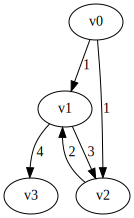

In [16]:
digraph1 = graphviz.Digraph()
digraph1.node("v0")
digraph1.node("v1")
digraph1.node("v2")
digraph1.node("v3")
digraph1.edge("v0", "v1", label='1')
digraph1.edge("v0", "v2", label='1')
digraph1.edge("v1", "v2", label='3')
digraph1.edge("v1", "v3", label='4')
digraph1.edge("v2", "v1", label='2')

save_graph_as_svg(digraph1.source, 'weighted_directed_graph_02')

이렇게 최적의 원칙이 어긋나는 알고리즘은 동적계획법으로 구현할 수 없다.
만약 동적 계획법으로 비순환 최장 경로를 생성하려 한다면 $v_0 \to v_1\to v_2$를 사용해야 하는데
그려면 $v_0$에서 $v_3$로의 비순환 최장 경로를 생성할 수 없기 때문이다.
결론적으로 동적 계획법으로 최적의 해를 얻기 위해서는 최적의 원칙이 성립해야 한다.

## 연습 문제

1. [(실습) 플로이드-워셜 알고리즘](https://colab.research.google.com/github/codingalzi/algopy/blob/master/excs/exc-dynamic_programming_2.ipynb)